In [4]:
#export
from src.nb_01 import *

In [2]:
#export
class BalancedAccuracy(Callback):
    def __init__(self, one_hot=False):
        super(BalancedAccuracy, self).__init__()
        self.one_hot = one_hot
        
    def on_epoch_begin(self, **kwargs):
        self.correct = np.zeros(16)
        self.total = np.zeros(16)
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        if self.one_hot:
            targs = last_target.argmax(1)
        else:
            targs = last_target
        for i in range(16):
            self.correct[i] += ((preds==i)*(targs==i)).float().sum()
            self.total[i] += (targs==i).float().sum()
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, (self.correct/self.total).mean())

## Modelos

### Toy dataset

In [3]:
labels = pd.read_csv('../data/interim/fixed_train.csv', usecols=['fileName', 'tag'])
labels['fileName'] = 'train/' + labels['fileName'].astype(str) + '.jpg'
google_labels = pd.read_csv('../data/external/google.csv')

Me quedo con algunas fotos de cada clase

In [4]:
n = 200
parts = []
for tag, idxs in labels.groupby('tag').groups.items():
    parts.append(labels.loc[idxs].sample(frac=1).iloc[:n])

In [5]:
toy_labels = pd.concat(parts).sample(frac=1)

In [6]:
trn_idx, val_idx = make_train_valid(toy_labels, shuffle=True, n_oversamples='auto')[0]

In [7]:
df_trn = toy_labels.iloc[trn_idx]
df_val = toy_labels.iloc[val_idx]
df_all = pd.concat([df_trn, df_val], axis=0)

In [8]:
#export
def change_bs(learner, new_bs=16):
    learner.data.train_dl.batch_size = new_bs
    learner.data.valid_dl.batch_size = new_bs*2
    learner.data.test_dl.batch_size = new_bs*2

### Sin softmax

In [9]:
#export
def bce_learner(labels, train_size, arch, pretrained=True, models_dir='..', **kwargs):
    one_hot = True
    data = get_data(labels, train_size, one_hot=one_hot, **kwargs)
    if pretrained:
        learn = cnn_learner(data, arch, metrics=[BalancedAccuracy(one_hot=one_hot)], 
                            bn_wd=False, path=models_dir)
    else:
        loss_func = BCEWithLogitsFlat()
        learn = Learner(data, arch(), loss_func = loss_func, 
                        metrics=[BalancedAccuracy(one_hot=one_hot)], 
                        bn_wd=False, path=models_dir)
    return learn

In [10]:
learn = bce_learner(df_all, len(df_trn), models.densenet121,
                    pretrained=True, bs=16, tfms=get_transforms(), size=299)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/schouhy/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:21<00:00, 1497000.19it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


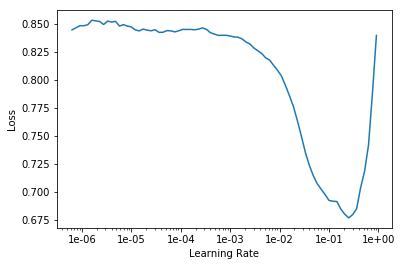

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
print('stage-1...')
learn.fit_one_cycle(4, 2e-2)

stage-1...


In [13]:
change_bs(learn, 16)
learn.unfreeze()

In [14]:
print('stage-2...')
learn.fit_one_cycle(4, slice(1e-6, 1e-4))

stage-2...


In [15]:
del learn
torch.cuda.empty_cache()

### Con softmax

In [184]:
#export
def cross_entropy_learner(labels, train_size, arch, pretrained=True, models_dir='..', **kwargs):
    one_hot = False
    data = get_data(labels, train_size, one_hot=one_hot, **kwargs)
    if pretrained:
        learn = cnn_learner(data, arch, metrics=[BalancedAccuracy(one_hot=one_hot)], path=models_dir)
    else:
        loss_func = CrossEntropyFlat()
        learn = Learner(data, arch(), loss_func = loss_func, 
                        metrics=[BalancedAccuracy(one_hot=one_hot)], 
                        path=models_dir)
    return learn

In [185]:
from functools import partial
learn = cross_entropy_learner(df_all, len(df_trn), partial(models.xresnet50, c_out=16),
                              pretrained=False, bs=16, tfms=get_transforms(), size=128)

print('stage-1...')
learn.fit_one_cycle(20, 1e-2)

stage-1...


In [ ]:
change_bs(learn, 16)
learn.unfreeze()

In [ ]:
print('stage-2...')
learn.fit_one_cycle(4, slice(1e-6, 1e-4))

In [ ]:
del learn
torch.cuda.empty_cache()

### Mixup

In [190]:
#export
def mixup_learner(labels, train_size, arch, pretrained=True, models_dir='..', **kwargs):
    return cross_entropy_learner(labels, train_size, arch, 
                                 pretrained=pretrained, models_dir=models_dir,
                                 **kwargs).mixup()

In [191]:
learn = mixup_learner(df_all, len(df_trn), partial(models.xresnet50, c_out=16), 
                      pretrained=False, bs=16, tfms=get_transforms(), size=128)

print('stage-1...')
learn.fit_one_cycle(20, 1e-2)

stage-1...


In [ ]:
change_bs(learn, 16)
learn.unfreeze()

In [ ]:
print('stage-2...')
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

In [192]:
del learn
torch.cuda.empty_cache()

### Label smoothing

In [12]:
#export
class LSBCEWithlogits(nn.Module):
    def __init__(self, epsilon, n_classes=16):
        super().__init__()
        self.bce = BCEWithLogitsFlat()
        self.epsilon = epsilon
        self.n = n_classes

    def forward(self, output, target):
        new_target = (1-self.epsilon)*target + self.epsilon*(1-target)/(self.n-1)
        return self.bce(output, new_target)

In [13]:
#export
def label_smoothing_bce_learner(labels, train_size, arch, epsilon=0.1, pretrained=True,
                                models_dir='../', **kwargs):
    loss_func = LSBCEWithlogits(epsilon)
    one_hot = True
    data = get_data(labels, train_size, one_hot=one_hot, **kwargs)
    if pretrained:
        learn = cnn_learner(data, arch, metrics=[BalancedAccuracy(one_hot=one_hot)], 
                            loss_func=loss_func, bn_wd=False, path=models_dir)
    else:
        learn = Learner(data, arch(), metrics=[BalancedAccuracy(one_hot=one_hot)], 
                        loss_func = loss_func, bn_wd=False, path=models_dir)
    return learn

In [14]:
learn = label_smoothing_bce_learner(df_all, len(df_trn), models.resnet50,
                                    pretrained=True, bs=16, tfms=get_transforms(), size=299)

In [18]:
print('stage-1...')
learn.fit_one_cycle(4, 1e-2)

stage-1...


In [19]:
change_bs(learn, 16)
learn.unfreeze()

print('stage-2...')
learn.fit_one_cycle(4, slice(1e-5, 1e-3))

stage-2...


## Export

In [13]:
!python notebook2script.py 02_models.ipynb

Converted 02_models.ipynb to ../src/nb_02.py
